In [1]:
# 1. Libraries and Settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import random
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from wordcloud import WordCloud
import warnings

warnings.filterwarnings('ignore')

In [2]:
# 2. Data Loading (Robust Path)
# We need to find the data file regardless of where the notebook is running
current_path = os.getcwd()
if 'notebooks' in current_path:
    data_path = '../data/cleaned_data.csv'
    model_dir = '../models'
    data_dir = '../data'
else:
    data_path = 'data/cleaned_data.csv'
    model_dir = 'models'
    data_dir = 'data'

# Create directories if they don't exist
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

try:
    df = pd.read_csv(data_path)
    print("✅ Dataset loaded successfully.")
except FileNotFoundError:
    print("❌ Error: Dataset not found. Please check your folder structure.")

✅ Dataset loaded successfully.


In [3]:
# 3. Synthetic Data Generation (The "Creative" Part)
# Since the original dataset has no reviews, we will generate synthetic reviews
# based on the Product Category and a random Sentiment Score.

print("\n⚙️ Generating synthetic customer reviews...")

# Word banks for generation
templates = {
    'Electronics': {
        'positive': ["Amazing battery life", "Super fast processor", "Great value for money", "Crystal clear screen", "Love this device"],
        'negative': ["Battery drains too fast", "Overheats quickly", "Screen arrived broken", "Too expensive for this quality", "Stopped working after a week"],
        'neutral': ["It's okay", "Decent performance", "Average quality", "Arrived on time", "Nothing special"]
    },
    'Clothing': {
        'positive': ["Fits perfectly", "High quality fabric", "Very comfortable", "Looks exactly like the picture", "Stylish and durable"],
        'negative': ["Size is too small", "Fabric feels cheap", "Color faded after wash", "Stitching came loose", "Not comfortable at all"],
        'neutral': ["Fits okay", "Material is average", "Good for the price", "Delivery was fast", "Standard quality"]
    },
    'Beauty': {
        'positive': ["Smells wonderful", "Skin feels soft", "Great texture", "Long lasting results", "Best product ever"],
        'negative': ["Caused a rash", "Smells terrible", "Bottle was leaking", "Did not work for me", "Waste of money"],
        'neutral': ["It's fine", "Smell is okay", "Works somewhat", "Packaging is nice", "Average results"]
    }
}

def generate_review(row):
    category = row['Product Category']

    # Assign a random sentiment score (1 to 5)
    # Weighted probabilities to make it realistic (more positives usually)
    score = np.random.choice([1, 2, 3, 4, 5], p=[0.1, 0.1, 0.2, 0.3, 0.3])

    # Determine label based on score
    if score >= 4:
        sentiment = 'Positive'
        text = random.choice(templates[category]['positive'])
    elif score <= 2:
        sentiment = 'Negative'
        text = random.choice(templates[category]['negative'])
    else:
        sentiment = 'Neutral'
        text = random.choice(templates[category]['neutral'])

    return pd.Series([score, text, sentiment])

# Apply the function to create new columns
df[['Review_Score', 'Review_Text', 'Sentiment']] = df.apply(generate_review, axis=1)

print("✅ Synthetic reviews generated.")
print(df[['Product Category', 'Review_Text', 'Sentiment']].head())


⚙️ Generating synthetic customer reviews...
✅ Synthetic reviews generated.
  Product Category                     Review_Text Sentiment
0           Beauty                   Great texture  Positive
1         Clothing  Looks exactly like the picture  Positive
2      Electronics            Super fast processor  Positive
3         Clothing             Stylish and durable  Positive
4           Beauty                Smells wonderful  Positive


In [4]:
# 4. Text Preprocessing
# Cleaning the text data for the model
def clean_text(text):
    text = text.lower() # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text) # Remove punctuation
    return text

df['Cleaned_Text'] = df['Review_Text'].apply(clean_text)

In [5]:
# 5. Vectorization (TF-IDF)
# Converting text into numbers
print("\n⚙️ Vectorizing text data (TF-IDF)...")
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
X = tfidf.fit_transform(df['Cleaned_Text']).toarray()
y = df['Sentiment']


⚙️ Vectorizing text data (TF-IDF)...


In [6]:
# 6. Model Training (Naive Bayes)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training the Sentiment Model (Naive Bayes)...")
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
print("✅ Model training completed.")

Training the Sentiment Model (Naive Bayes)...
✅ Model training completed.



🎯 Model Accuracy: 97.50%

📊 Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      0.88      0.93        40
     Neutral       1.00      1.00      1.00        30
    Positive       0.96      1.00      0.98       130

    accuracy                           0.97       200
   macro avg       0.99      0.96      0.97       200
weighted avg       0.98      0.97      0.97       200



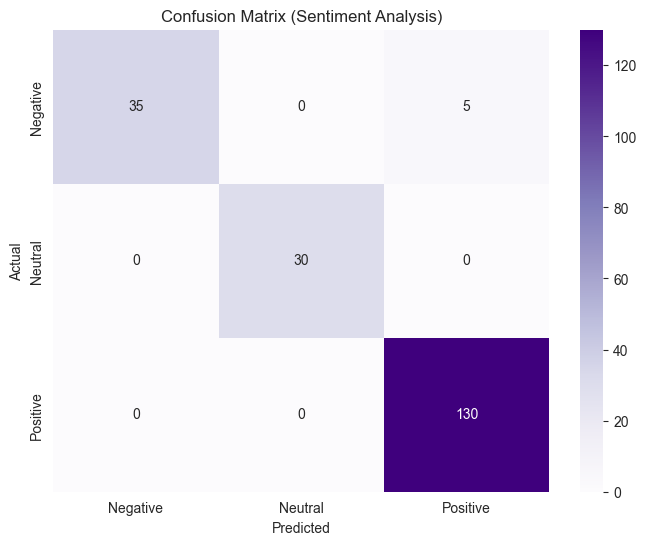

In [7]:
# 7. Evaluation
y_pred = nb_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"\n🎯 Model Accuracy: {acc*100:.2f}%")
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=nb_model.classes_, yticklabels=nb_model.classes_)
plt.title('Confusion Matrix (Sentiment Analysis)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

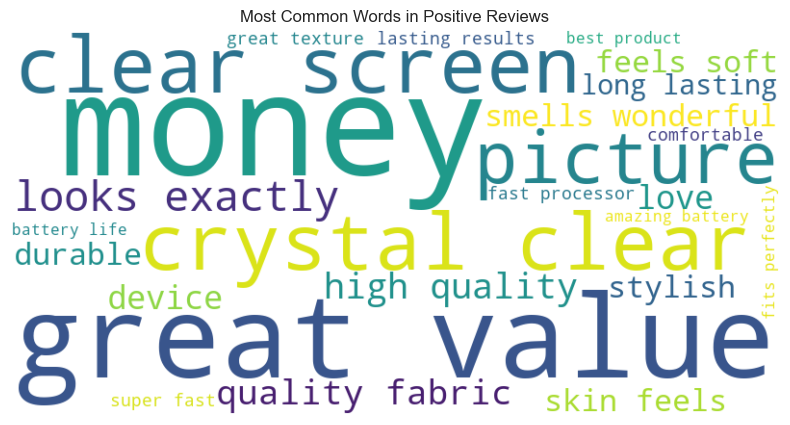

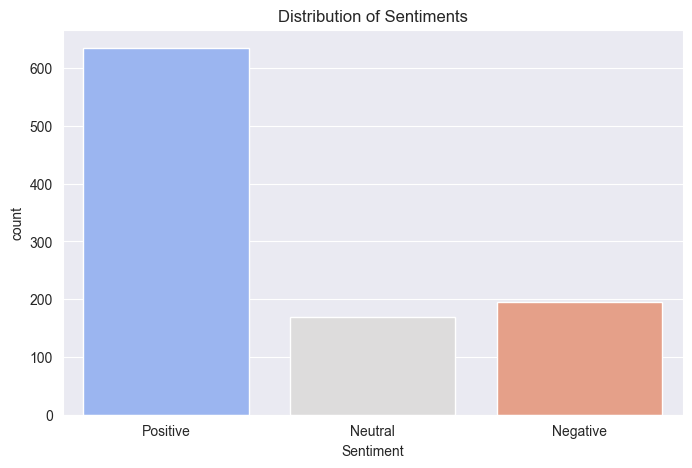

In [8]:
# 8. Visualization: Word Cloud
# Shows the most frequent words in Positive reviews
# Note: In a real environment, you might need to install wordcloud (pip install wordcloud)
try:
    positive_text = " ".join(df[df['Sentiment'] == 'Positive']['Cleaned_Text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Most Common Words in Positive Reviews')
    plt.show()
except Exception as e:
    print(f"⚠️ Could not generate WordCloud: {e}")

# Visualization: Sentiment Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='Sentiment', data=df, palette='coolwarm', order=['Positive', 'Neutral', 'Negative'])
plt.title('Distribution of Sentiments')
plt.show()

In [9]:
# 9. Model Export
# Saving both the model AND the vectorizer (crucial for UI)
model_path = os.path.join(model_dir, 'sentiment_model.pkl')
vectorizer_path = os.path.join(model_dir, 'tfidf_vectorizer.pkl')
data_export_path = os.path.join(data_dir, 'data_with_reviews.csv')

joblib.dump(nb_model, model_path)
joblib.dump(tfidf, vectorizer_path)
df.to_csv(data_export_path, index=False)

print(f"\n💾 Model saved to: {model_path}")
print(f"💾 Vectorizer saved to: {vectorizer_path}")
print(f"💾 Data with reviews saved to: {data_export_path}")


💾 Model saved to: ../models\sentiment_model.pkl
💾 Vectorizer saved to: ../models\tfidf_vectorizer.pkl
💾 Data with reviews saved to: ../data\data_with_reviews.csv
